In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


In [2]:
import os
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir('../data'))
df = pd.read_csv('../data/diabetes.csv')

Current working directory: /Users/khalilur/Documents/python/artificial-intelligence/ANN/code
Files in the directory: ['diabetes.csv']


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
class_counts = df['Outcome'].value_counts()
print(class_counts)

Outcome
0    500
1    268
Name: count, dtype: int64


In [6]:
df_cleaned = df.dropna()
print("Null values after cleaning:")
print(df_cleaned.isnull().sum())

Null values after cleaning:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [8]:
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
print(len(X_train))
print(len(X_test))

614
154


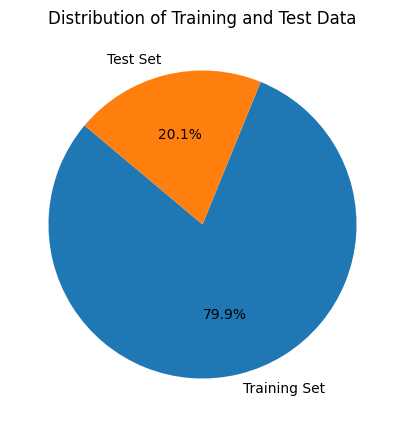

In [11]:
sizes = [len(X_train), len(X_test)]
labels = ['Training Set', 'Test Set']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Training and Test Data')
plt.show()

In [12]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [13]:
class ANN_model(nn.Module):
    # For ANN we will require input layer, hidden layer and output layer
    def __init__(self, input_features=8, hidden1=20, hidden2=20, out_features=2):
        # Inherit parent class i.e.nn.Module
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1, hidden2)
        self.out=nn.Linear(hidden2,out_features)
    # x will track the gradient descent and all the propogation
    def forward(self,x):
        # F we have all the activation functions
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=self.out(x)
        return x

In [14]:
model = ANN_model()

In [15]:
print(model.parameters)

<bound method Module.parameters of ANN_model(
  (f_connected1): Linear(in_features=8, out_features=20, bias=True)
  (f_connected2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)>


In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [17]:
def train_model(model, X_train, y_train, epochs=10):
    loss_values = []

    for epoch in tqdm(range(epochs), desc='Training Epochs'):
        model.train()

        # Forward pass
        y_pred = model(X_train)

        # Compute loss
        loss = loss_function(y_pred, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (epoch + 1) == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    return loss_values

loss_values = train_model(model, X_train, y_train, epochs=1000)

Training Epochs: 100%|██████████| 1000/1000 [00:00<00:00, 1990.70it/s]


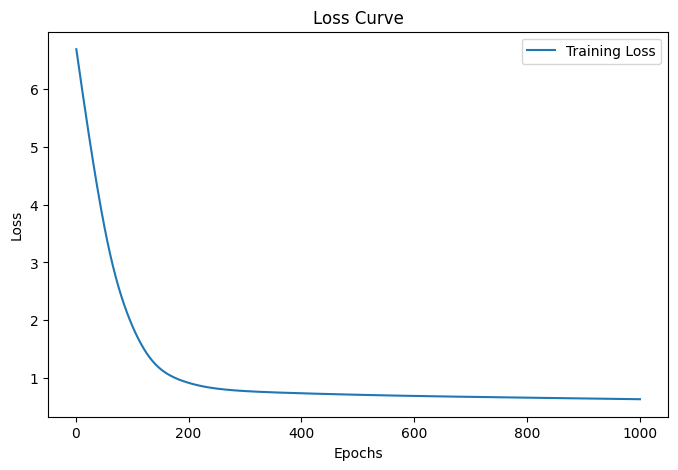

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [19]:

def evaluate_model_with_class_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

        # Get predicted class labels
        _, predicted = torch.max(y_pred, 1)

        # Calculate overall accuracy
        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
        print(f'Overall Accuracy: {accuracy:.4f}')

        # Generate and print classification report
        report = classification_report(y_test.numpy(), predicted.numpy(), target_names=class_names)
        print("\nClassification Report:\n", report)

        # Calculate per-class accuracy
        for i, class_name in enumerate(class_names):
            class_accuracy = accuracy_score(y_test.numpy()[y_test.numpy() == i], predicted.numpy()[y_test.numpy() == i])
            print(f'Accuracy for {class_name}: {class_accuracy:.4f}')

class_names = ['0', '1']
evaluate_model_with_class_accuracy(model, X_test, y_test)

Overall Accuracy: 0.6623

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74        99
           1       0.53      0.49      0.51        55

    accuracy                           0.66       154
   macro avg       0.63      0.62      0.63       154
weighted avg       0.66      0.66      0.66       154

Accuracy for 0: 0.7576
Accuracy for 1: 0.4909


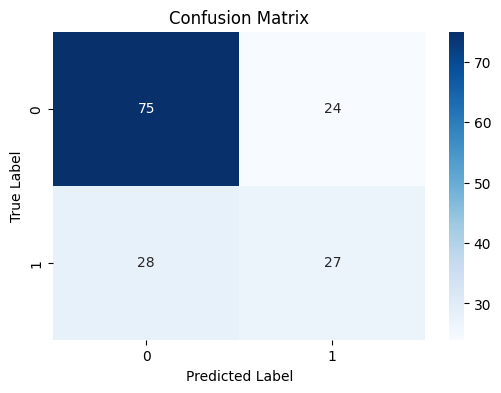

In [20]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = model(X_test).argmax(dim=1).numpy()
plot_confusion_matrix(y_test.numpy(), y_pred, class_names)